# Mega Case Study - Make a Hybrid Deep Learning Model

## Part 1 - Identify the Frauds with the Self-Organizing Map

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


### Importing the dataset

In [3]:
script_dir = os.path.dirname('__file__')
training_set_path = os.path.join(script_dir, 'Credit_Card_Applications.csv')
dataset = pd.read_csv(training_set_path)
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values


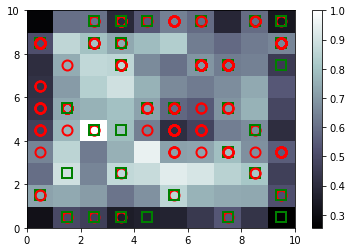

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)

# Training the SOM
from minisom import MiniSom

som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show

bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor=colors[y[i]],
         markerfacecolor='None',
         markersize=10,
         markeredgewidth=2)
show()



### Finding the frauds

In [6]:

mappings = som.win_map(X)
frauds = np.concatenate((mappings[(2, 4)], mappings[(5, 1)]), axis=0)
frauds = sc.inverse_transform(frauds)

## Part 2 - Going from Unsupervised to Supervised Deep Learning

### Creating the matrix of features

In [7]:

customers = dataset.iloc[:, 1:].values

# Creating the dependent variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds:
        is_fraud[i] = 1


### Feature Scaling

In [8]:

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customers = sc.fit_transform(customers)


## Part 2 - Now let's make the ANN!

In [10]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim=15))

# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(customers, is_fraud, batch_size=1, epochs=5)


Epoch 1/5
690/690 [==============================] - 1s 2ms/step - loss: 0.4555 - accuracy: 0.9986
Epoch 2/5
690/690 [==============================] - 1s 2ms/step - loss: 0.1667 - accuracy: 1.0000
Epoch 3/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 1.0000
Epoch 4/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 5/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 1.0000


## Predicting the probabilities of frauds

In [11]:

y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis=1)
y_pred = y_pred[y_pred[:, 1].argsort()]
